In [1]:
import numpy as np
import torch
import pandas as pd

import matplotlib.pyplot as plt

from collections import namedtuple
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import data_processing as dp
import model
import model_utilities as util
import vocab
import batch_samplers

In [3]:
import importlib

In [4]:
importlib.reload(model)

<module 'model' from '/media/itasarom/7158f0d7-af1d-45d4-855f-86204aed5a8b/Projects/diplom/GAN/model.py'>

In [5]:
def normalize_embeddings(embeddings):
    EPS = 1e-9
    mean = embeddings.mean(axis=0, keepdims=True)
    se = (embeddings.var(axis=0, keepdims=True)  + EPS )**0.5
    
    return (embeddings - mean)/se

In [6]:
# vocab1, all_labels, sents1, labels1 = dp.load_problem(lang='ma')
# vocab2, all_labels, sents2, labels2 = dp.load_problem(lang='es')
vocab1, all_labels, sents1, labels1 = dp.load_problem(lang='ru')
vocab2, all_labels, sents2, labels2 = dp.load_problem(lang='en')

In [7]:
vocab1.embeddings = normalize_embeddings(vocab1.embeddings)
vocab2.embeddings = normalize_embeddings(vocab2.embeddings)

In [8]:
# vocab1.embeddings.var(axis=0)

In [9]:
len(vocab1.embeddings), len(vocab2.embeddings)

(176032, 47404)

In [10]:
torch.cuda.is_available()

True

In [11]:
sent_sampler_1 = batch_samplers.BatchSamplerRegularizer(sents=sents1, labels=labels1, vocab=vocab1, all_labels=all_labels)

In [12]:
sent_sampler_2 = batch_samplers.BatchSamplerRegularizer(sents=sents2, labels=labels2, vocab=vocab2, all_labels=all_labels)

In [13]:
embed_sampler_1 = batch_samplers.BatchSamplerDiscriminator(vocab1)

In [14]:
embed_sampler_2 = batch_samplers.BatchSamplerDiscriminator(vocab2)

In [15]:
import IPython


In [16]:
cls = model.GAN(100, len(all_labels))

In [17]:
cls = cls.cuda()

In [31]:
# params = {
#     'save_path': "./model_checkpoint.tc",
#     'save_every':10,
#     'sentence_iterations':200,
#     'discr_iterations':1,
#     'transform_iterations':500,
#     'n_sents_1':128,
#     'n_sents_2':128,
#     'n_discr_1':128,
#     'n_discr_2':128,
#     'n_iter':20
    
# }

# params = {
#     'save_path': "./model_checkpoint.tc",
#     'save_every':10,
#     'sentence_iterations':2,
#     'discr_iterations':1,
#     'transform_iterations':5,
#     'n_sents_1':128,
#     'n_sents_2':128,
#     'n_discr_1':128,
#     'n_discr_2':128,
#     'n_iter':20
    
# }

# params = {
#     'save_path': "./model_checkpoint_2_layers.tc",
#     'save_every':10,
#     'sentence_iterations':200,
#     'discr_iterations':10,
#     'transform_iterations':20,
#     'n_sents_1':128,
#     'n_sents_2':128,
#     'n_discr_1':1024,
#     'n_discr_2':1024,
#     'n_iter':100
    
# }


params = {
    'save_path': "./model_checkpoint_new.tc",
    'save_every':10,
    'sentence_iterations':200,
    'discr_iterations':10,
    'transform_iterations':20,
    'n_sents_1':128,
    'n_sents_2':128,
    'n_discr_1':1024,
    'n_discr_2':1024,
    'n_iter':1
    
}

In [32]:
# trainer.global_iterations = 60

In [21]:
trainer = util.Trainer(cls)

In [22]:
# trainer.restore("./model_checkpoint_2_layers.tc")
# cls.train()

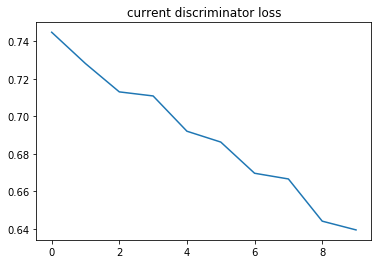

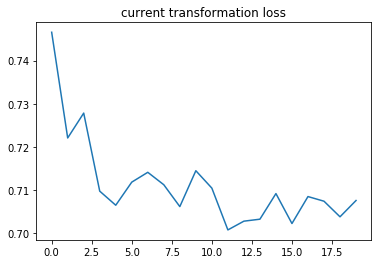

Iter 1000 class -1.0, discr0.6894971132278442, transform 0.7113355398178101


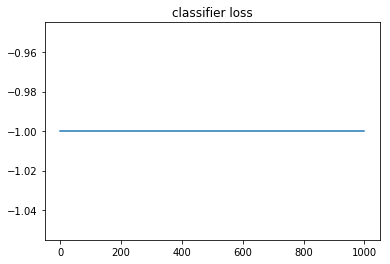

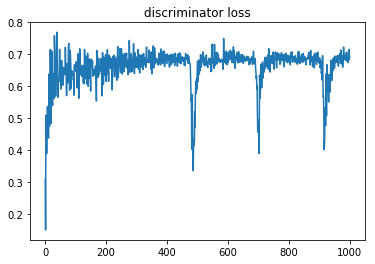

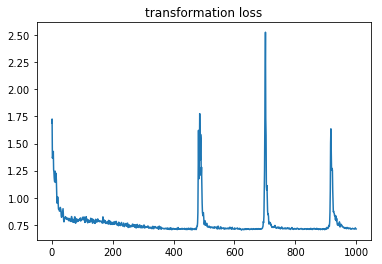

In [33]:
# trainer.t
trainer.train(sent_sampler_1, sent_sampler_2, embed_sampler_1, embed_sampler_2, params)

In [25]:
import sklearn
from sklearn.metrics import log_loss, accuracy_score

In [26]:
def build_confusion_matrix(predicted_probs, true_y):
    n_labels = predicted_probs.shape[1]
#     assert true_y.shape == predicted_probs.shape
    result = np.zeros(shape=(n_labels, n_labels))
    
    pred = predicted_probs.argmax(axis=1)
#     true = true_y.argmax(axis=1)
    true = true_y
    
    for pred_cls in range(n_labels):
        for true_cls in range(n_labels):
            result[true_cls, pred_cls] = np.count_nonzero(true[pred == pred_cls] == true_cls)
#     norm = result.sum(axis=1)
#     norm = np.maximum(norm, 1)
#     result /= norm[:, None]
    return result


In [27]:
def get_probs(transformation, model, embeddings, batch_size, use_cuda):
    result = []
#     embed_sum = 0.0
#     squares_sum = 0.0
    embeds = []
    for position in range(0, len(embeddings), batch_size):
        x = embeddings[position:position + batch_size]
        x = torch.autograd.Variable(torch.from_numpy(x)).float()
        if use_cuda:
            x = x.cuda()
        
        x = transformation(x)
        _, probs = model.discriminator.forward(x)
        probs = probs.data.cpu().numpy()
        result.append(probs)
        
        x = x.cpu().data.numpy()
#         embed_sum += x
        embeds.append(x)
    
    result = np.vstack(result)
    z = 1 - result
    result = np.hstack([z, result])
    return result, np.vstack(embeds)

In [28]:
def validate(model, embeddings_1, embeddings_2, batch_size, use_cuda):
    probs_1, t1 = get_probs(model.transform1, model, embeddings_1, batch_size, use_cuda)
    probs_2, t2 = get_probs(model.transform2, model, embeddings_2, batch_size, use_cuda)
    probs = np.vstack([probs_1, probs_2])
    
    pred_1 = probs_1.argmax(axis=1).reshape(-1, 1)
    pred_2 = probs_2.argmax(axis=1).reshape(-1, 1)    
    pred = np.vstack([pred_1, pred_2])
    
    y_true = np.concatenate([np.zeros((len(pred_1),)), np.ones((len(pred_2)))])
    
    
    acc = accuracy_score(y_pred=pred, y_true=y_true)
    loss = log_loss(y_pred=probs, y_true=y_true)
    cm = build_confusion_matrix(probs, y_true)
    plt.hist(probs[y_true == 0, 1], bins=100, label="0")
    plt.hist(probs[y_true == 1, 1], bins=100, label="1")
    
    plt.legend()
    plt.show()
    
    t = np.vstack([t1, t2])
    
    return acc, loss, cm, probs, y_true , t
    

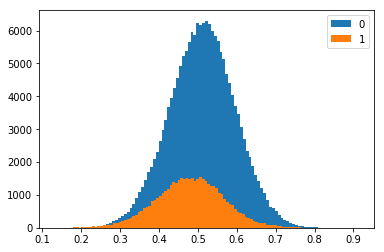

Accuracy  0.4375078322204121
Loss  0.7356540635074101
Confusion matrix
 [[78203. 97829.]
 [27852. 19552.]]
Min component variance 0.004507964476943016, median component variance 0.008392741903662682, mean component variance 0.008946085348725319, max c v 0.022350413724780083
Total length  223436


In [29]:
cls.eval()
result = validate(cls, vocab1.embeddings, vocab2.embeddings, 200, use_cuda=True)
print("Accuracy ", result[0])
print("Loss ", result[1])
print("Confusion matrix\n", result[2])
vars = result[-1].var(axis=0)
print("Min component variance {}, median component variance {}, mean component variance {}, max c v {}".format(
        min(vars), np.median(vars), np.mean(vars), max(vars)
    ))
print("Total length ", len(result[-1]))

In [45]:
# cls.discriminator.actual_model.zero_grad()

In [34]:
embeds = result[-1]

In [35]:
embeds = normalize_embeddings(embeds)

In [36]:
embeds1 = embeds[:len(vocab1.embeddings)]
embeds2 = embeds[len(vocab1.embeddings):]

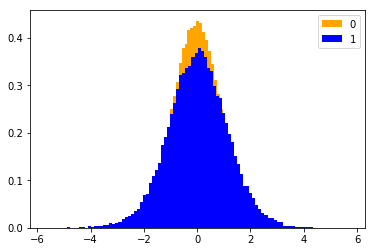

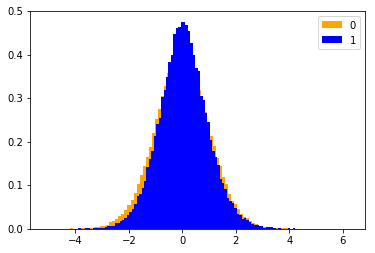

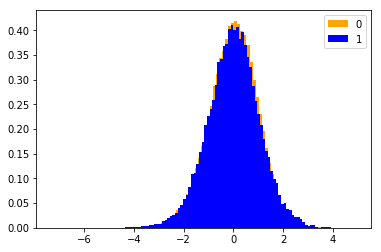

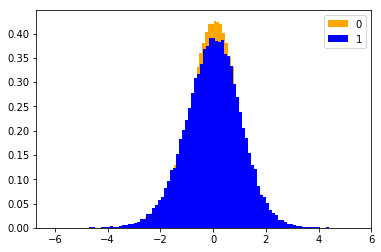

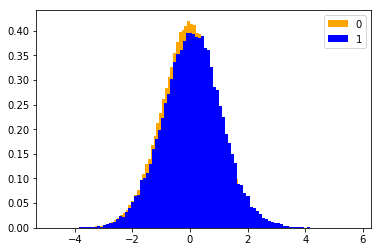

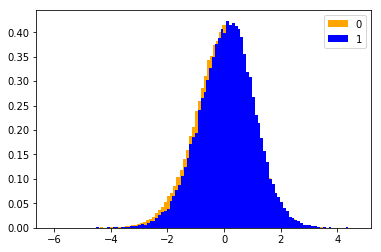

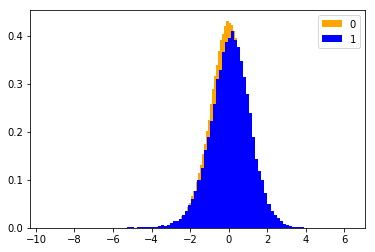

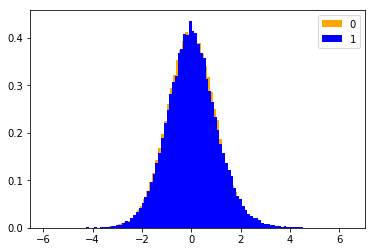

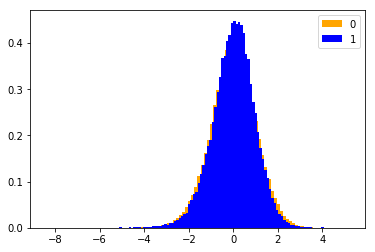

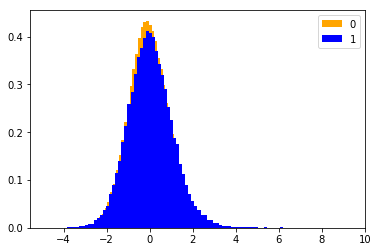

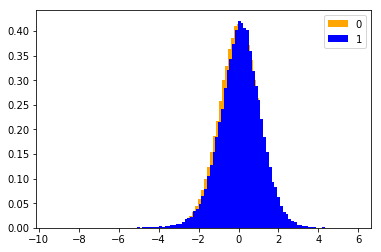

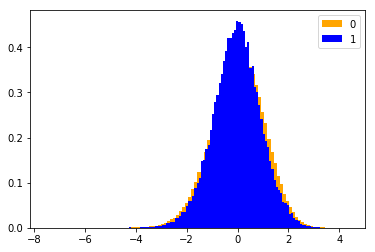

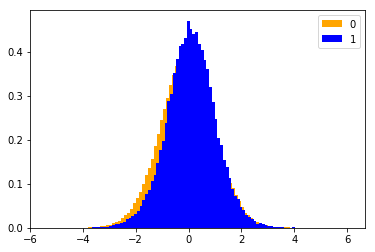

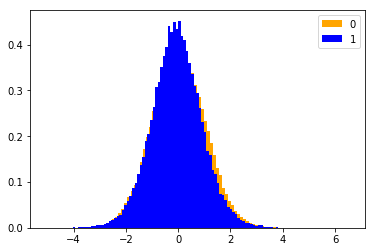

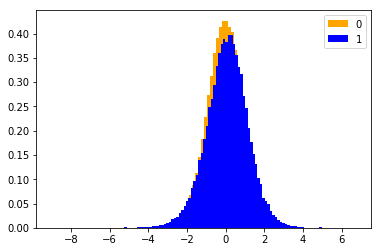

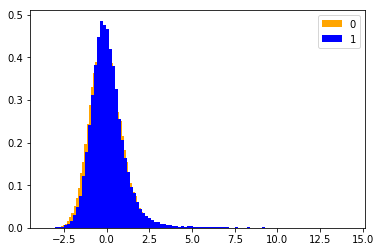

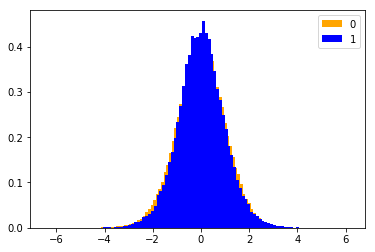

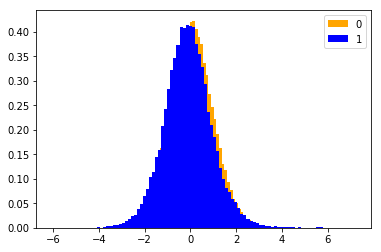

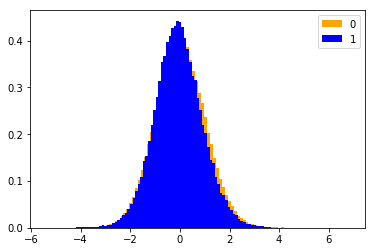

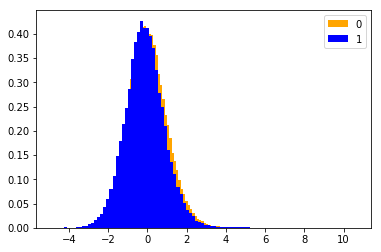

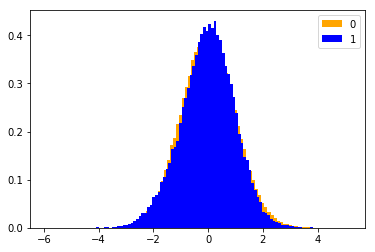

KeyboardInterrupt: 

In [ ]:
for i in range(100):
    plt.hist(embeds1[:, i], color='orange', bins=100, label='0', normed=True)
    plt.hist(embeds2[:, i], color='blue', bins=100, label='1', normed=True)
    plt.legend()
    plt.show()

In [173]:
def plot_word_by_id(t1, t2, ids, dims):
    plt.figure(figsize=(20, 20))
#     plt.scatter(t1[ids, 0], t1[ids, 1], color='r')
#     plt.scatter(t2[ids, 0], t2[ids, 1], color='b')
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    for id in ids:
        plt.annotate(e[id], (t1[id, dims[0]], t1[id, dims[1]]), color='r', fontsize=15)
        plt.annotate(f[id], (t2[id, dims[0]], t2[id, dims[1]]), color='b', fontsize=15)
#     plt.annotate(e)
#         print(id)
    plt.show()

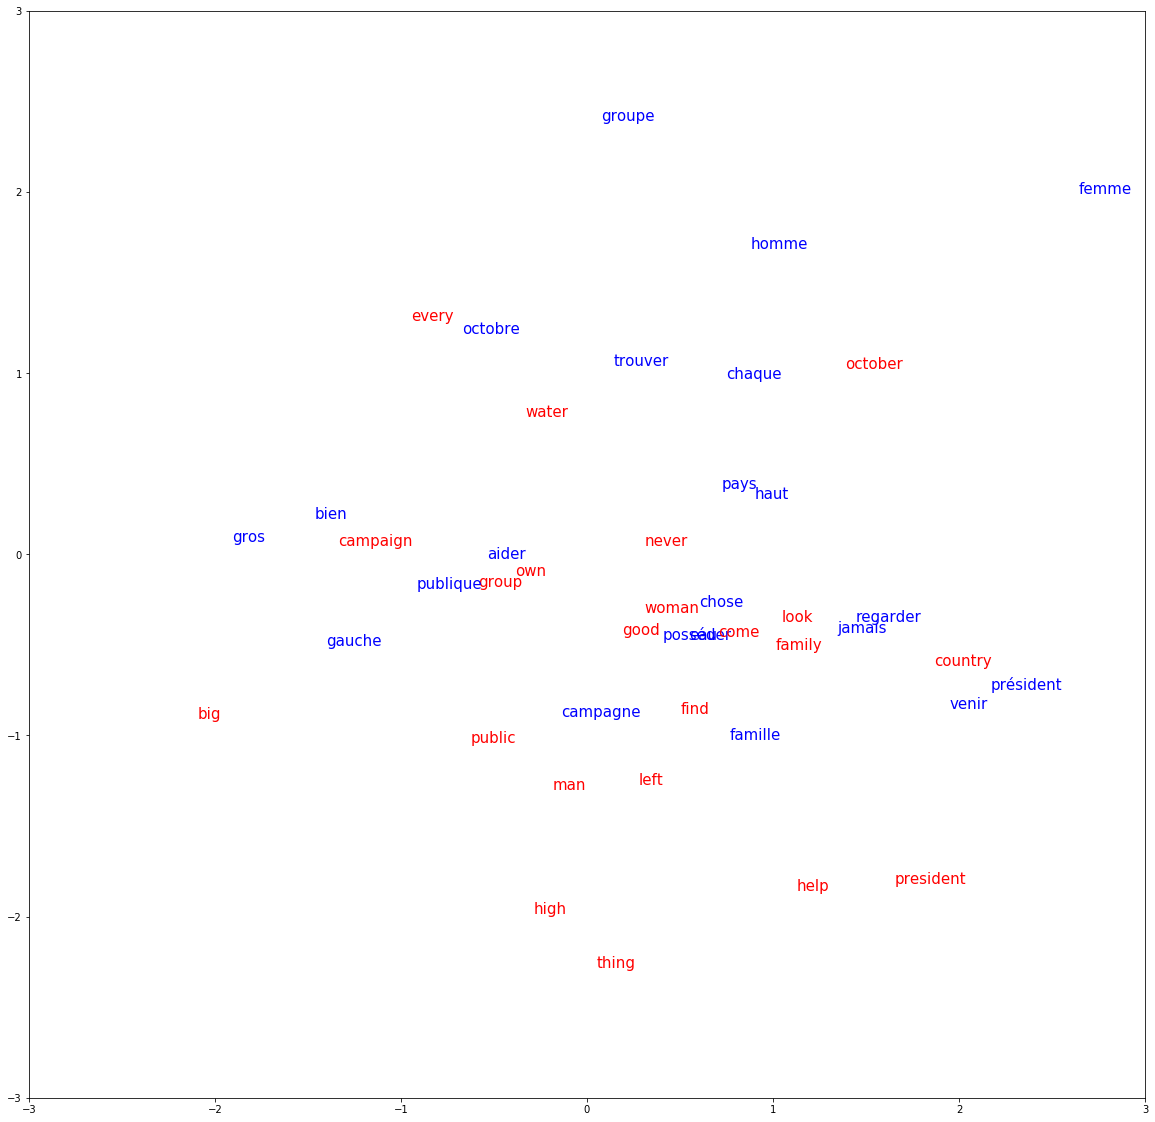

In [174]:
plot_word_by_id(embeds1[vocab1.transform_one(f)], embeds2[vocab2.transform_one(e)], range(len(e)), dims=[12, 49])

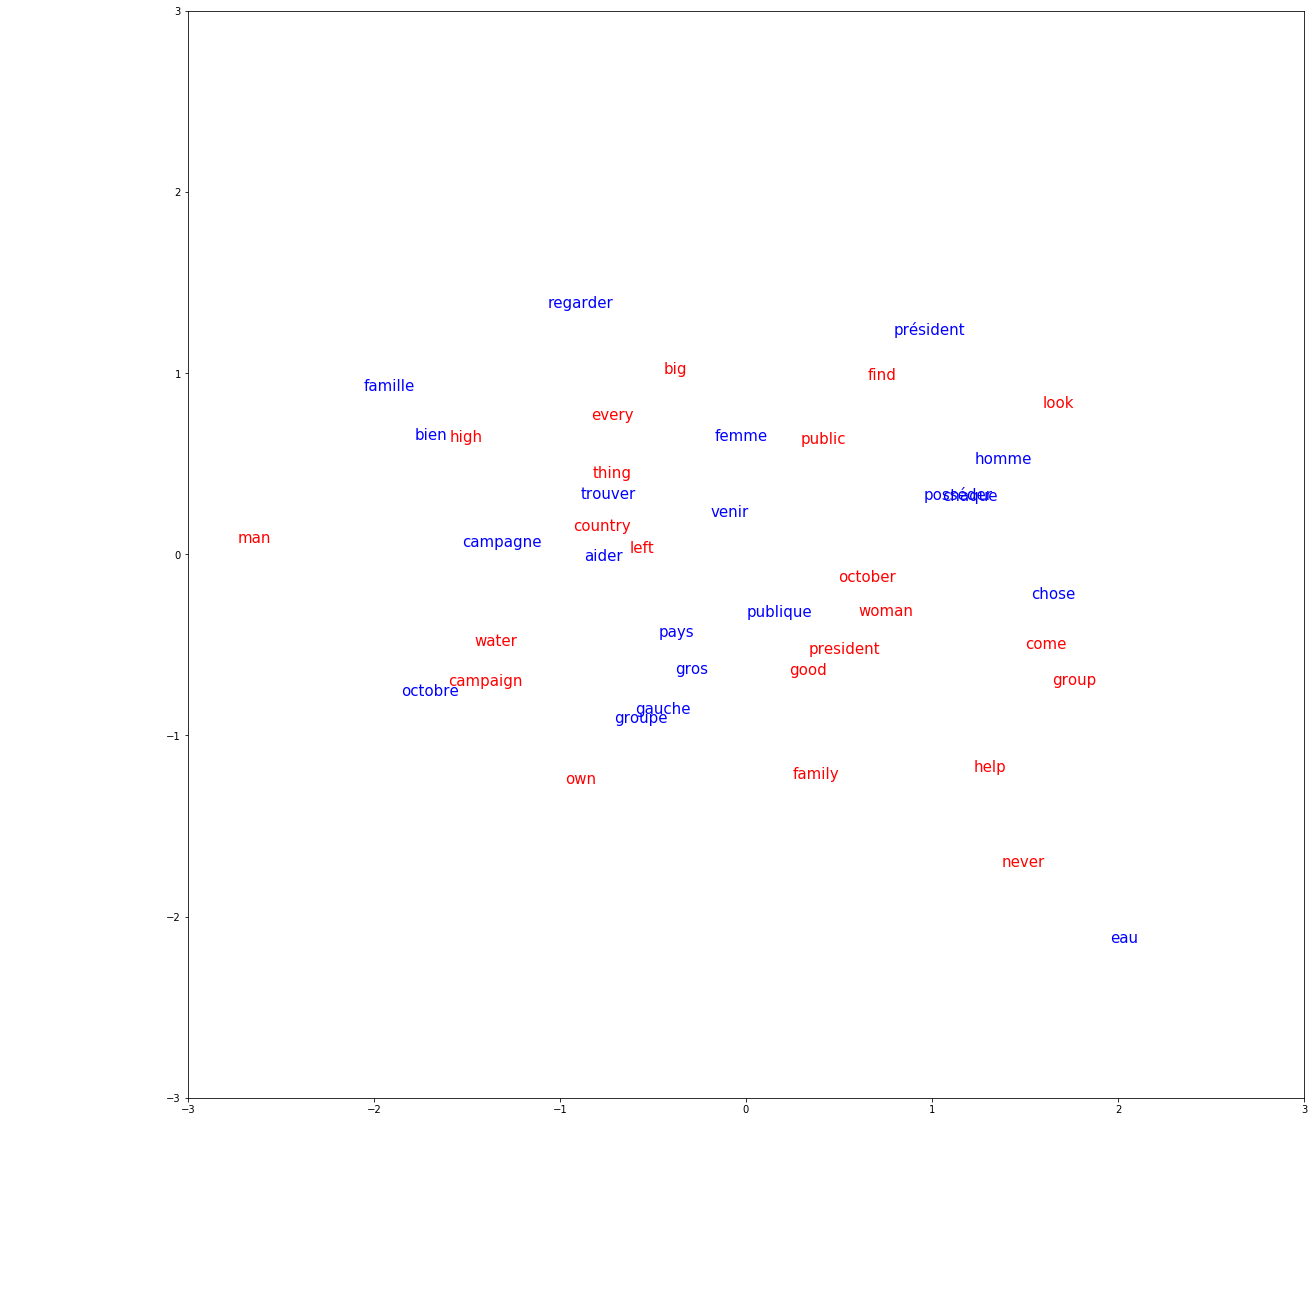

In [175]:
plot_word_by_id(embeds1[vocab1.transform_one(f)], embeds2[vocab2.transform_one(e)], range(len(e)), dims=[2, 3])

array([15225,  9215,  2346,  3547, 14988, 11624,  5261,  3192,  7628,
        2503,  4126, 12670, 20520, 10947, 21938,   352, 17673, 19283,
       13128,  6281,  9860, 12282,    40], dtype=int32)

In [352]:
y_[pred == y_]

array([0, 0, 0, ..., 1, 1, 1])

In [357]:
def plot_confusion_matrix(confusion_matrix):
    fig = plt.figure( figsize=(20, 20))
    plt.xlabel("True classes")
    plt.ylabel("Predicted classes")
    sns.heatmap(confusion_matrix, annot=True, vmin=0.0, vmax=1.0, cmap="YlGnBu")

In [358]:
# plot_confusion_matrix(cm)

In [359]:
cm[1][0]

1938.0

In [360]:
cm

array([[4348.,  652.],
       [1938., 3062.]])

(array([1.647e+03, 3.028e+03, 4.135e+03, 1.133e+03, 1.400e+01, 1.400e+01,
        1.100e+01, 4.000e+00, 7.000e+00, 7.000e+00]),
 array([0.35679463, 0.41784872, 0.4789028 , 0.53995689, 0.60101098,
        0.66206507, 0.72311916, 0.78417325, 0.84522734, 0.90628143,
        0.96733552]),
 <a list of 10 Patch objects>)

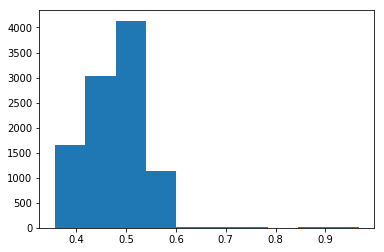

In [140]:
np.count_nonzero(probs[:, 0] < 0.999) / len(probs)

1.0

In [141]:
a = x2.cpu().data.numpy()

In [53]:
b = x1.cpu().data.numpy()

In [54]:
x2 = x2.data.cpu().numpy()

In [55]:
x2_old = x2_old.data.cpu().numpy()

In [56]:
x1 = x1.data.cpu().numpy()

In [57]:
v1 = x1.var(axis=1)

In [58]:
v2 = x2.var(axis=1)

In [59]:
v1.mean(), v2.mean()

(0.11046429, 102.2626)

In [60]:
x1[:, 23].mean(), x2[:, 23].mean()

(-0.02716727, 12.107327)

In [61]:
a[:, 2].min(), a[:, 2].max()

(-3.7124705, 174.79897)

In [62]:
b[:, 1].min(), b[:, ].max()

(-1.4277, 2.6908)

In [63]:
v1[0]

0.16367291

In [64]:
v2_t[0]

NameError: name 'v2_t' is not defined

In [65]:
import sklearn.metrics as skms

In [74]:
skms.pairwise.cosine_similarity(x1[:5], x2[:5]).ravel()

array([ 0.39520594,  0.30639488,  0.44650787,  0.1645084 ,  0.35313922,
        0.26134342,  0.16894002,  0.20646647, -0.02554763,  0.20384546,
        0.5050079 ,  0.34302565,  0.29202652,  0.41267747,  0.53470004,
        0.16313905,  0.21574289,  0.22009766,  0.22442156,  0.2420528 ,
        0.06621529,  0.07761168, -0.05406904,  0.35286176,  0.1814011 ],
      dtype=float32)

In [75]:
skms.pairwise.cosine_similarity(x1[:5], x2_old[:5]).ravel()

array([ 0.11918166,  0.02951451, -0.0456996 ,  0.01172976,  0.181189  ,
        0.00820952, -0.06260593, -0.07489959, -0.02220186, -0.01885154,
        0.10764948, -0.00161014,  0.07105204,  0.07839131,  0.04724923,
       -0.18810102, -0.18871957, -0.12664916, -0.11190072,  0.05522443,
       -0.17025638, -0.1770258 ,  0.02469893, -0.05895214, -0.04473685],
      dtype=float32)

In [226]:
from sklearn.decomposition import PCA

In [227]:
pca = PCA(n_components=2)

In [228]:
pca.fit(vocab1.embeddings)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [84]:
transformed_x1 = pca.transform()

In [33]:
b2 = embed_sampler_2.get_batch(32).astype(np.float32)
# x2 = x2.cuda()
b2_t = torch.autograd.Variable(torch.from_numpy(b2)).cuda()
b2_t = cls.transform2(b2_t)

In [43]:
transformed_x2 = pca.transform(b2)

In [44]:
transformed_x2_t = pca.transform(b2_t.data.cpu().numpy())

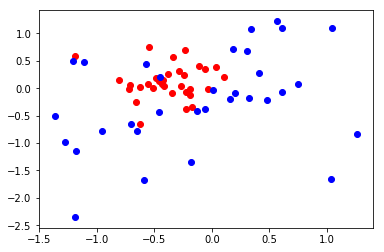

In [46]:
# plt.scatter(transformed_x1[:, 0], transformed_x1[:, 1])
plt.scatter(transformed_x2[:, 0], transformed_x2[:, 1], color='r')
plt.scatter(transformed_x2_t[:, 0], transformed_x2_t[:, 1], color='b')

In [23]:
for v in vocab2.words[200:225]:
    print(v)

help
family
group
look
own
president
top
man
come
october
big
every
things
30
women
9
found
public
ll
campaign
set
left
better
country
never


In [112]:
e = """
help
family
group
look
own
president
high
man
come
october
big
every
thing
woman
find
public
campaign
water
left
good
country
never
"""
e = [w.strip() for w in e.split("\n") if len(w) > 1]

In [113]:
f = """
aider
famille
groupe
regarder
posséder
président
haut
homme
venir
octobre
gros
chaque
chose
femme
trouver
publique
campagne
eau
gauche
bien
pays
jamais
"""
f = [w.strip() for w in f.split("\n") if len(w) > 1]

In [114]:
# cls = cls.cpu()
from sklearn.decomposition import PCA

In [115]:
pca = PCA(n_components=2)

In [233]:
all_x1 = torch.autograd.Variable(torch.from_numpy(vocab1.embeddings).float()).cuda()

In [33]:
# all_x1t = cls.transform1(all_x1)
# all_x1t = all_x1t.cpu().data.numpy()

In [42]:
pca.fit(all_x1t)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [43]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [36]:
x1 = vocab1.get_word_embeddings(f).astype(np.float32)
x1 = torch.autograd.Variable(torch.from_numpy(x1)).cuda()
x1_t = cls.transform1(x1)

In [38]:
x2 = vocab2.get_word_embeddings(e).astype(np.float32)
x2 = torch.autograd.Variable(torch.from_numpy(x2)).cuda()
x2_t = cls.transform2(x2)

In [44]:
t1 = pca.transform(x1_t.data.cpu().numpy())

In [45]:
t2 = pca.transform(x2_t.data.cpu().numpy())

In [46]:
# t2_t = pca.transform(x2_t.data.cpu().numpy())

In [117]:
plot_word_by_id(, t2, None, list(range(22)))

NameError: name 't1' is not defined